# Basic CNN

## Import Libraries

In [17]:
import torch, torchvision
from torch import nn
from torch import optim
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

In [18]:
import requests
from PIL import Image
from io import BytesIO

import copy

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [21]:
numb_batch = 64


## Getting Data

In [68]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

## Create Model

In [71]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

## Validate model

In [73]:
def validate(model, data):
    device = torch.device("cpu")  # Specify CPU device
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)  # Move data to CPU
        x = model(images)
        _, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels.to(device))  # Move labels to CPU
    return correct.item() * 100. / total

## Training function

In [74]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

## GPU Availability

In [75]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

No Cuda Available


device(type='cpu')

## Training the model

Saving Best Model with Accuracy:  95.93
Epoch: 1 Accuracy : 95.93 %
Saving Best Model with Accuracy:  97.36
Epoch: 2 Accuracy : 97.36 %
Saving Best Model with Accuracy:  98.15
Epoch: 3 Accuracy : 98.15 %
Saving Best Model with Accuracy:  98.48
Epoch: 4 Accuracy : 98.48 %
Saving Best Model with Accuracy:  98.7
Epoch: 5 Accuracy : 98.7 %
Saving Best Model with Accuracy:  98.72
Epoch: 6 Accuracy : 98.72 %
Saving Best Model with Accuracy:  98.78
Epoch: 7 Accuracy : 98.78 %
Saving Best Model with Accuracy:  98.83
Epoch: 8 Accuracy : 98.83 %
Epoch: 9 Accuracy : 98.78 %
Saving Best Model with Accuracy:  98.88
Epoch: 10 Accuracy : 98.88 %


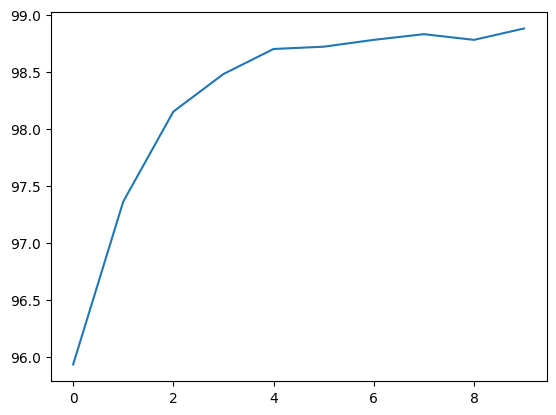

In [77]:
lenet = train(10, device=device)

## Function to test validation data

In [59]:
def predict_dl(model, data):
    device = torch.device("cpu")  # Specify CPU device
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.to(device)  # Move data to CPU
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.numpy()  # Move predictions to CPU
        y_pred.extend(list(pred))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

## Get prediction for any given image

In [47]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

## Getting the image from the web

In [49]:
path = "https://previews.123rf.com/images/moji1980/moji19801210/moji1980121000088/15691005-4-handwritten-watercolor-number-isolated-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

Original image:
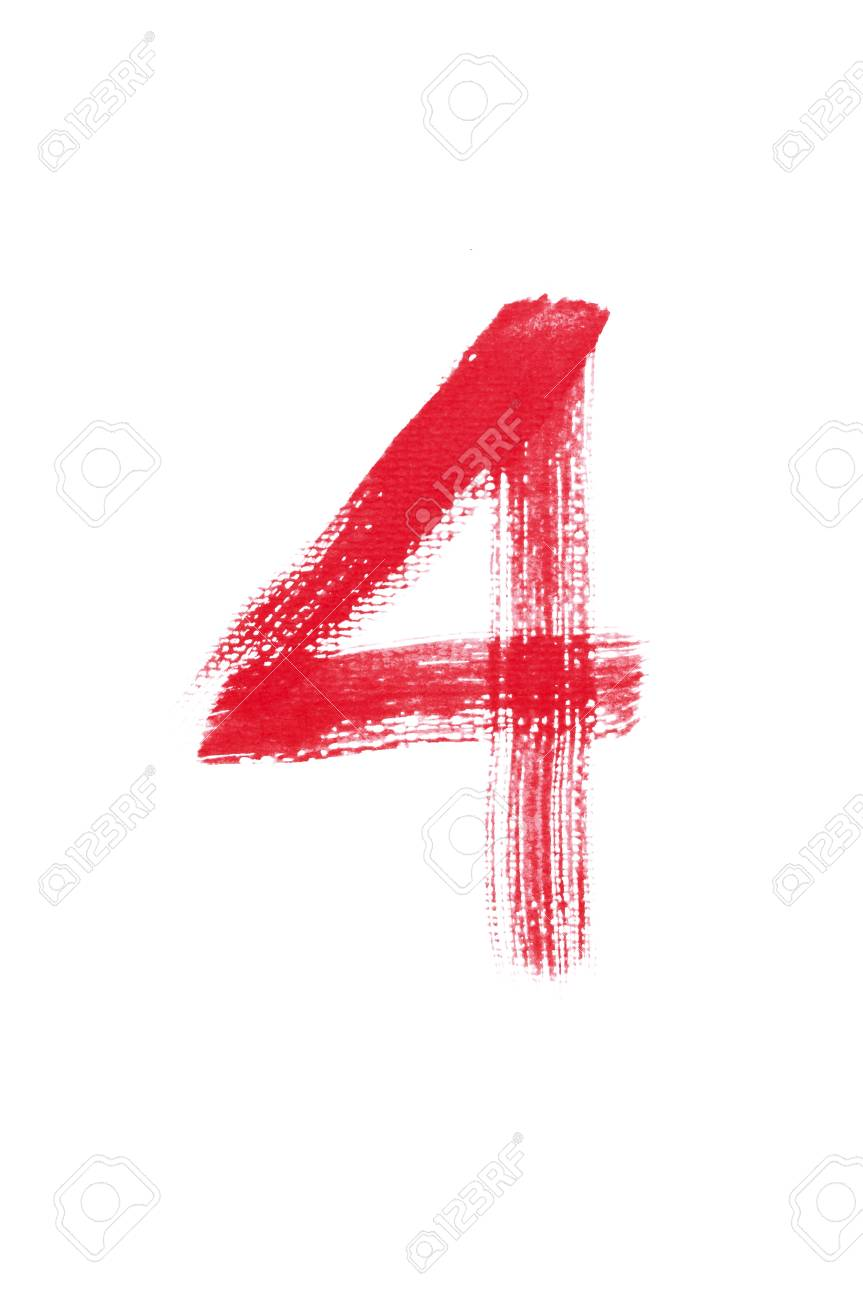

## Show the image

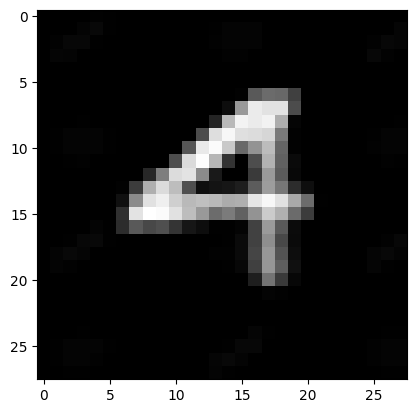

In [ ]:
plt.imshow(x.squeeze(-1), cmap="gray")

## Predictions


In [81]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 9, Prob: 68.73291730880737 %


## Metrics

In [82]:
y_pred, y_true = predict_dl(lenet, val_dl)

# Accuracy
accuracy = validate(lenet, val_dl)
print('Accuracy: {:.2f}%'.format(accuracy))

# F1 Score
y_pred, y_true = predict_dl(lenet, val_dl)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: {:.2f}'.format(f1))


Accuracy: 98.88%
F1 Score: 0.99


# R-CNN

## Create model

In [63]:
# Define the region proposal network
class RegionProposalNetwork(nn.Module):
    def __init__(self):
        super(RegionProposalNetwork, self).__init__()
        # Define layers for region proposal
        # You can customize this based on your requirements
        # Example:
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Implement region proposal algorithm here
        # Placeholder implementation
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

# Define the R-CNN model
class RCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(RCNN, self).__init__()
        # Region proposal layer
        self.region_proposal = RegionProposalNetwork()
        # Region-based CNN layers
        # You can customize this based on your requirements
        # Example:
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Forward pass through the RPN (Region Proposal Network)
        regions = self.region_proposal(x)

        # Forward pass through the RCNN (Region-based Convolutional Neural Network)
        # Placeholder implementation
        regions = regions.view(regions.size(0), -1)
        x = self.fc1(regions)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

## Function to train model

In [64]:
def train(model, train_loader, val_loader, num_epochs=3, lr=1e-3, device=torch.device("cpu")):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {end_time - start_time:.2f} sec")

    return model, train_losses, val_losses

## Train model

In [65]:
# Create and train the R-CNN model
rcnn = RCNN().to(device)
rcnn, train_losses, val_losses = train(rcnn, train_dl, val_dl, num_epochs=3, lr=1e-3, device=device)

Epoch [1/3], Train Loss: 0.1766, Val Loss: 0.0630, Time: 57.36 sec
Epoch [2/3], Train Loss: 0.0500, Val Loss: 0.0389, Time: 61.48 sec
Epoch [3/3], Train Loss: 0.0306, Val Loss: 0.0469, Time: 61.71 sec


## Prediction (same image: "4")

In [66]:
pred = inference(path, rcnn, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 4, Prob: 95.79354524612427 %


## Metrics

In [67]:
y_pred, y_true = predict_dl(rcnn, val_dl)

# Accuracy
accuracy = validate(rcnn, val_dl)
print('Accuracy: {:.2f}%'.format(accuracy))

# F1 Score
y_pred, y_true = predict_dl(rcnn, val_dl)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: {:.2f}'.format(f1))


Accuracy: 98.58%
F1 Score: 0.99


# AlexNet

## Create model

In [30]:
# Load pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Freeze all layers except the last fully connected layer
for param in alexnet.parameters():
    param.requires_grad = False

alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 10  # Example: if you have 10 classes
alexnet.classifier[6] = nn.Linear(4096, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 50.1MB/s]


## Prepare dataset

In [44]:
# Define transformation for the dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize images to match AlexNet input size
    torchvision.transforms.ToTensor()
])

# Load the MNIST dataset
full_train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
full_val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

# Create a subset of the MNIST dataset (for demonstration, selecting first 1000 samples)
subset_train_indices = range(100)
subset_val_indices = range(100)  # You can modify this to create a validation subset
subset_train_data = Subset(full_train_data, subset_train_indices)
subset_val_data = Subset(full_val_data, subset_val_indices)

# Create data loaders for the subsets
train_loader = torch.utils.data.DataLoader(subset_train_data, batch_size=numb_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(subset_val_data, batch_size=numb_batch, shuffle=False)

## Fine tune model

In [45]:
alexnet, train_losses, val_losses = train(alexnet, train_loader, val_loader, num_epochs=3, lr=0.001, device=device)

Epoch [1/3], Train Loss: 2.2772, Val Loss: 2.2906, Time: 142.70 sec
Epoch [2/3], Train Loss: 2.2426, Val Loss: 2.2507, Time: 135.15 sec
Epoch [3/3], Train Loss: 2.2242, Val Loss: 2.2226, Time: 135.18 sec


## Prediction (same image: "4")

In [57]:
pred = inference(path, alexnet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 7, Prob: 19.036056101322174 %


## Metrics

In [62]:
y_pred, y_true = predict_dl(alexnet, val_dl)

# Accuracy
accuracy = validate(alexnet, val_dl)
print('Accuracy: {:.2f}%'.format(accuracy))

# F1 Score
y_pred, y_true = predict_dl(alexnet, val_dl)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: {:.2f}'.format(f1))


Accuracy: 13.71%
F1 Score: 0.05


# VIT

## Patchifying images function

In [83]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

## Positional Embeddings

In [84]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

## Define model

In [85]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

## Create model

In [86]:
vit = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 2
LR = 0.01

## Prepare data

In [87]:
# Loading data
transform = ToTensor()

train_set = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=128)

## Train model

In [88]:
# Training loop
optimizer = Adam(vit.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = vit(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:  50%|█████     | 1/2 [03:32<03:32, 212.60s/it]

Epoch 1/2 loss: 2.06



Training: 100%|██████████| 2/2 [07:05<00:00, 212.92s/it]

Epoch 2/2 loss: 1.83


## Prediction (same image: "4")

In [89]:
pred = inference(path, vit, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 1, Prob: 22.894857823848724 %


## Metrics

In [91]:
y_pred, y_true = predict_dl(vit, val_dl)

# Accuracy
accuracy = validate(vit, val_dl)
print('Accuracy: {:.2f}%'.format(accuracy))

# F1 Score
y_pred, y_true = predict_dl(vit, val_dl)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: {:.2f}'.format(f1))


Accuracy: 65.35%
F1 Score: 0.63
